In [117]:
%load_ext autoreload
%autoreload 2
#%matplotlib tk

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import LocaNMF

import torch
import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load & Format Data

In [118]:
# Folder where the data is stored
# data location

data_folder = '/media/cat/10TB/in_vivo/tim/yuki/IA2/tif_files/IA2pm_Feb3_30Hz/'

Uc_fname = data_folder + 'Vs.npy'
Vc_fname = data_folder + 'u.npy'

# user params
minrank = 1; maxrank = 1; # rank = how many components per brain region. Set maxrank to around 4 for regular dataset.
rank_range = (minrank, maxrank, 1)
min_pixels = 100 # minimum number of pixels in Allen map for it to be considered a brain region
loc_thresh = 70 # Localization threshold, i.e. percentage of area restricted to be inside the 'Allen boundary'
r2_thresh = 0.99 # Fraction of variance in the data to capture with LocaNMF

device='cuda'
#new_x, new_y = 580, 540 # New x and y

# load the data and stuffs
# Check that data has the correct shapes. V [K_d x T], U [X x Y x K_d], brainmask [X x Y]
K_d = 500
V=np.load(Vc_fname).T[:K_d]
print("Required V [K_d x T]: ", V.shape)
U=np.load(Uc_fname).transpose(1,2,0)[:,:,:K_d]
print("Required U [X x Y x K_d]: ", U.shape)

# load Brainmask
# brain mask
if False:
    fname_mask = data_folder+'brainmask.npy'
    brainmask=np.load(fname_mask)
    print ("Brainmask: ", brainmask.shape)
    brainmask_full=~np.isnan(brainmask)
    brainmask=~np.isnan(brainmask[:new_y, :new_x])
    print ("Brainmask: ", brainmask.shape)

else:
    brainmask = np.ones((U.shape[0],U.shape[1]),'bool')
    
#print ("NOTE: Both V and U have been multiplied by S")
print ("DONE")

Required V [K_d x T]:  (500, 39050)
Required U [X x Y x K_d]:  (128, 128, 500)
DONE


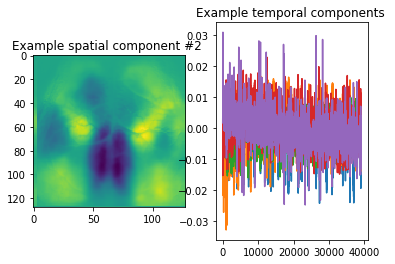

In [119]:
# plot example spatial and temporal components
ax=plt.subplot(121)
plt.imshow(U[:,:,2])
plt.title("Example spatial component #2 ")
ax=plt.subplot(122)
plt.title("Example temporal components ")
plt.plot(V[:5].T)
plt.show()

(128, 128)
(285,)


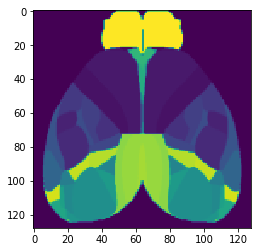

In [160]:
# Get region based Allen map

#data = sio.loadmat(data_folder+'warped_atlas.mat')
#print (data)
#dorsalMapScaled = data['atlas']
dorsalMapScaled = np.rint(np.load('/media/cat/10TB/in_vivo/tim/yuki/IA2/tif_files/IA2pm_Feb1_30Hz/warped_atlas_128.npy'))
plt.imshow(dorsalMapScaled)
print (dorsalMapScaled.shape)
print (np.unique(dorsalMapScaled).shape)

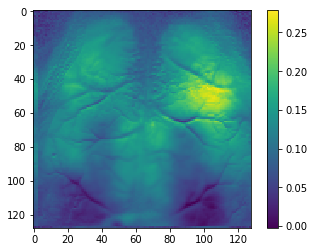

In [161]:
# Plot example frame
frame1=np.matmul(U,V[:,4]); plt.imshow(frame1); plt.colorbar(); plt.show()

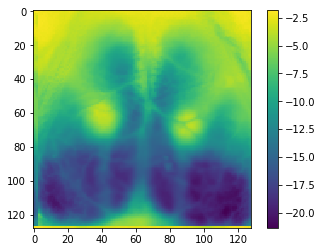

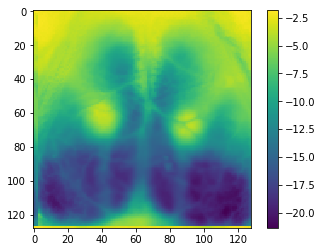

In [162]:
# If brainmask does not exactly align with mask applied to data
Umasked=U; 
Umasked[~brainmask]=np.nan; 
plt.imshow(Umasked[:,:,0]); 
plt.colorbar(); 
plt.show()

Umasked=np.reshape(Umasked,(128*128,500))
maskout=np.where(np.all(Umasked==0,axis=1))[0]

brainmask=np.reshape(brainmask,(128*128)); 
brainmask[maskout]=0; 
brainmask=np.reshape(brainmask,(128,128))

Umasked=U; 
Umasked[~brainmask]=np.nan; 
plt.imshow(Umasked[:,:,0]); 
plt.colorbar(); 
plt.show()

In [163]:
# Perform the LQ decomposition. Time everything.
t0_global = time.time()
t0 = time.time()
q, r = np.linalg.qr(V.T)
time_ests={'qr_decomp':time.time() - t0}

# Initialize LocaNMF

In [164]:
# Put in data structure for LocaNMF
video_mats = (np.copy(U[brainmask]), r.T)
#del U

In [165]:
valid_mask = brainmask
region_map = dorsalMapScaled

In [166]:
# region_mats[0] = [unique regions x pixels] the mask of each region
# region_mats[1] = [unique regions x pixels] the distance penalty of each region
# region_mats[2] = [unique regions] area code
region_mats = LocaNMF.extract_region_metadata(valid_mask,
                                              region_map,
                                              min_size=rank_range[1])

In [167]:
print (region_mats[0].shape, region_mats[1].shape, region_mats[2].shape)

(257, 16384) (257, 16384) (257,)


In [168]:
print (brainmask.shape, dorsalMapScaled, min_pixels, video_mats)

(128, 128) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 100 (array([[-1.9377471e+00, -8.5615391e-01,  7.9568245e-02, ...,
         2.0373082e-02, -8.2665533e-03,  4.0142331e-02],
       [-1.8527426e+00, -8.0438399e-01,  9.0088867e-02, ...,
        -9.3036033e-03, -6.6987649e-02,  3.2011788e-02],
       [-1.9076968e+00, -7.8793329e-01,  7.9858981e-02, ...,
         7.2187670e-02, -1.2750241e-01,  1.5701875e-01],
       ...,
       [-2.2987111e+00, -1.0269959e+00,  1.8671793e-01, ...,
         1.9214185e-01,  4.7940831e-03,  4.5233626e-02],
       [-2.4696274e+00, -1.0338882e+00,  1.5009792e-01, ...,
         3.4176055e-02,  7.9322085e-03,  1.7270340e-02],
       [-2.2092307e+00, -9.0448987e-01,  1.1599681e-01, ...,
        -8.8914100e-04, -3.0900486e-02,  5.3852275e-02]], dtype=float32), array([[ 1.0000089e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.000

In [169]:
region_metadata = LocaNMF.RegionMetadata(region_mats[0].shape[0],
                                       region_mats[0].shape[1:],
                                       device=device)

In [170]:
region_metadata.set(torch.from_numpy(region_mats[0].astype(np.uint8)),
                    torch.from_numpy(region_mats[1]),
                    torch.from_numpy(region_mats[2].astype(np.int64)))

In [171]:
# Do SVD
if device=='cuda': torch.cuda.synchronize()
print('v SVD Initialization')
t0 = time.time()
region_videos = LocaNMF.factor_region_videos(video_mats,
                                           region_mats[0],
                                           rank_range[1],
                                           device=device)
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['svd_init'] = time.time() - t0

v SVD Initialization
'-total : 0.431500


torch.Size([500, 16384])


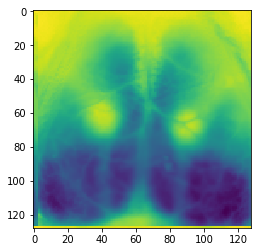

In [172]:
low_rank_video = LocaNMF.LowRankVideo(
    (int(np.sum(valid_mask)),) + video_mats[1].shape, device=device
)
low_rank_video.set(torch.from_numpy(video_mats[0].T),
                   torch.from_numpy(video_mats[1]))
print (low_rank_video.spatial.shape)
plt.imshow(low_rank_video.spatial.data[0].reshape(128,128).cpu().data.numpy())

# Do LocaNMF

In [173]:
if device=='cuda': torch.cuda.synchronize()
print('v Rank Line Search')
t0 = time.time()
print (maxrank, minrank)
debug = LocaNMF.rank_linesearch(low_rank_video,
                              region_metadata,
                              region_videos,
                              maxiter_rank=maxrank-minrank+1,
                              maxiter_lambda=400, #maxiter_lambda=1, 
                              maxiter_hals=20,
                              lambda_step=1.35,
                              lambda_init=1e-19, #lambda_init=0, 
                              loc_thresh=loc_thresh,
                              r2_thresh=r2_thresh,
                              rank_range=rank_range,
                              verbose=[True, False, False],
                              sample_prop=(1,1),
                              device=device
                             )
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['rank_linesearch'] = time.time() - t0

v Rank Line Search
1 1
|--v Rank Line Search Iteration 0
|  |--v Initialization
|  |  '-total : 0.052251 seconds
|  |--v Lambda Line Search
Removing components, num remaining: 256
Removing components, num remaining: 255
Removing components, num remaining: 254
Removing components, num remaining: 0


ValueError: Number of components 0 out of range:[1,257].

In [139]:
print("Number of components : %f" % len(debug))

Number of components : 254.000000


In [140]:
# Evaluate R^2
_,r2_fit=LocaNMF.evaluate_fit_to_region(low_rank_video,debug,region_metadata.support.data.sum(0),sample_prop=(1, 1))
print("R^2 fit on all data : %f" % r2_fit)
time_ests['global_time'] = time.time()-t0_global


R^2 fit on all data : 0.012238


In [141]:
# Assigning regions to components
region_ranks = []; region_idx = []
for rdx in torch.unique(debug.regions.data, sorted=True):
    region_ranks.append(torch.sum(rdx == debug.regions.data).item())
    region_idx.append(rdx.item())
#print (region_mats[2].shape,region_ranks.shape)
areas=np.repeat(region_mats[2][:len(region_ranks)],region_ranks,axis=0)

In [142]:
# Get LocaNMF spatial and temporal components, with A normalized to be <= 1
A=debug.spatial.data.cpu().numpy().T
max_A=np.zeros(A.shape[1])
for i in np.arange(A.shape[1]):
    max_A[i]=np.max(A[:,i])
    A[:,i]=A[:,i]/max_A[i]
A_reshape=np.zeros((brainmask.shape[0],brainmask.shape[1],A.shape[1])); A_reshape.fill(np.nan)
A_reshape[brainmask,:]=A

C=np.matmul(q,debug.temporal.data.cpu().numpy().T).T
for i in np.arange(C.shape[0]):
    C[i,:]=C[i,:]*max_A[i]


# Plotting Components and Lambdas

In [143]:
# Plotting all the regions' components
A_validmask=np.zeros((brainmask.shape[0],brainmask.shape[1])); A_validmask.fill(np.nan)

#for rdx, i in zip(region_idx, np.cumsum(region_ranks)-1):
for rdx, i in zip(region_idx, np.cumsum(region_ranks)-1)[:10]:
    fig, axs = plt.subplots(1, 3,figsize=(16,3))
    axs = axs.reshape((int(np.prod(axs.shape)),))
    A_validmask[brainmask] = debug.distance.data[i].cpu()==0
    axs[0].imshow(A_validmask)
    axs[0].set_title("Region: {}".format(rdx+1)); axs[0].axis('off')
        
    axs[1].imshow(A_reshape[:,:,i])
    axs[1].set_title("LocaNMF A: {}".format(i+1)); axs[1].axis('off')
    
    axs[2].plot(C[i,:500].T,'r');
    axs[2].set_title("LocaNMF C: {}".format(i+1)); #axs[2].axis('off'); 
    #
    plt.show()

TypeError: 'zip' object is not subscriptable

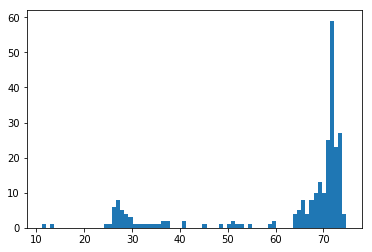

In [103]:
# Plot the distribution of lambdas. 
# If lots of values close to the minimum, decrease lambda_init.
# If lots of values close to the maximum, increase maxiter_lambda or lambda_step.
plt.hist(np.log(debug.lambdas.data.cpu()), bins=torch.unique(debug.lambdas.data).shape[0])
plt.show()

# Reformat spatial and temporal matrices, and save

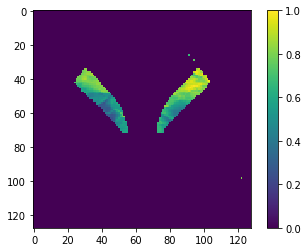

In [104]:
# Plot an example component
plt.imshow(A_reshape[:,:,1]); plt.colorbar(); plt.show()

In [105]:
print (A_reshape.shape)

(128, 128, 254)


In [109]:
#datafolder = '/media/cat/10TB/in_vivo/tim/yuki/IA2/tif_files/IA2pm_Feb1_30Hz/'

sio.savemat(data_folder+'locanmf_decomp_loc'+str(loc_thresh)+'.mat',
            {'C':C,
             'A':A_reshape,
             'lambdas':debug.lambdas.data.cpu().numpy(),
             'areas':areas,
             'r2_fit':r2_fit,
             'time_ests':time_ests
            })

np.savez(data_folder+'locanmf_decomp_loc'+str(loc_thresh),
            C=C,
             A=A_reshape,
             lambdas=debug.lambdas.data.cpu().numpy(),
             areas=areas,
             r2_fit=r2_fit,
             time_ests=time_ests)

In [26]:
torch.cuda.empty_cache()